In [1]:
import ROOT as rt
from root_numpy import root2array, tree2array

import h5py
import numpy as np
import numpy.lib.recfunctions as nlr
import pandas as pd
import os, sys
from matplotlib import pyplot as plt
import math
import json
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

from root_pandas import read_root
#import keras
#from keras.models import Sequential
#from keras import layers

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from prettytable import PrettyTable

import gpustat
gpustat.print_gpustat()
os.environ['CUDA_VISIBLE_DEVICES']='3'
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

Welcome to JupyROOT 6.18/02


ModuleNotFoundError: No module named 'root_pandas'

In [2]:
year = '2017'

SIGNAL_DIR = '/bigdata/shared/HHbbgg/flashggTreeBSMWeights/signal/'
SIGNAL_NODES = [2,3,4,7,9,12]
SIGNAL_FILE = SIGNAL_DIR+'output_GluGluToHHTo2B2G_allnode_13TeV-madgraph_correctedcfg.root'

# BKG_FILE = '/bigdata/shared/HHbbgg/flashggTree'+year+'/output_ttHToGG_M125_13TeV_powheg_pythia8.root'
# if year == '2016':
#     BKG_FILE = '/bigdata/shared/HHbbgg/flashggTree2016/output_ttHToGG_M125_13TeV_powheg_pythia8_v2.root'
BKG_DIR = '/bigdata/shared/HHbbgg/flashggTreeBSMWeights/bkg/'
#BKG_NAMES = [
#     'output_GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8.root',
#             'output_GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8.root',
#             'output_GluGluHToGG_M-125_13TeV_powheg_pythia8.root']
BKG_NAMES = 'output_ttHToGG_M125_13TeV_powheg_pythia8.root'
#BKG_FILES = [BKG_DIR+x for x in BKG_NAMES]
BKG_FILE = BKG_DIR+BKG_NAMES
print(BKG_FILE)

/bigdata/shared/HHbbgg/flashggTreeBSMWeights/bkg/output_ttHToGG_M125_13TeV_powheg_pythia8.root


In [3]:
NORM_CONSTANT = {"benchmark_10_normalization": 8.26328, 
                 "benchmark_7_normalization": 8.02758, 
                 "benchmark_2_normalization": 8.20958, 
                 "benchmark_9_normalization": 8.6845, 
                 "benchmark_6_normalization": 8.79, 
                 "benchmark_4_normalization": 7.52522, 
                 "benchmark_3_normalization": 8.45029, 
                 "benchmark_1_normalization": 6.30071, 
                 "benchmark_8_normalization": 7.47232, 
                 "benchmark_5_normalization": 8.24452, 
                 "benchmark_11_normalization": 8.70954, 
                 "benchmark_0_normalization": 7.99948}

### Add weights and normalize BSM nodes

In [4]:
def convert(tree, target=0):

    branches = ['event', 'weight', 
                'ttH_sumET','ttH_MET','ttH_phiMET','ttH_dPhi1','ttH_dPhi2','ttH_PhoJetMinDr',
                'ttH_njets','ttH_Xtt0','ttH_Xtt1','ttH_pte1','ttH_pte2',
                'ttH_ptmu1','ttH_ptmu2','ttH_ptdipho',
                'ttH_etae1','ttH_etae2','ttH_etamu1','ttH_etamu2','ttH_etadipho',
                'ttH_phie1','ttH_phie2','ttH_phimu1','ttH_phimu2','ttH_phidipho',
                'ttH_fabs_CosThetaStar_CS','ttH_fabs_CosTheta_bb',
                'ttH_ptjet1','ttH_ptjet2','ttH_etajet1','ttH_etajet2',
                'ttH_phijet1','ttH_phijet2',
                                     ]
    
    if target==1:
        for i in range(0,12):
            branches.append('benchmark_reweight_{}'.format(i))
        branches.append('benchmark_reweight_SM')
    
    feature = tree2array(tree,
                        branches=branches)
    
    if target == 0:
        label = np.zeros(shape = feature.shape, dtype=[('label','f4')])
    else:
        label = np.ones(shape = feature.shape, dtype=[('label','f4')])
    #data = nlr.merge_arrays([label,feature], flatten=True)
    #auxInfo = tree2array(tree,
    #                     branches = ['mass_jj','mass_gg'])
    return feature #, auxInfo

sigfile = rt.TFile.Open(SIGNAL_FILE)
bkgfile = rt.TFile.Open(BKG_FILE)
#bkgfile2 = rt.TFile.Open(BKG_FILE2)


# Add 12 separated trees
for i in range(12):
    
    sigtree_ = sigfile.Get("tagsDumper/trees/GluGluToHHTo2B2G_nodesPlusSM_13TeV_madgraph_13TeV_DoubleHTag_{}".format(i))
    bkgtree_ = bkgfile.Get("tagsDumper/trees/ttHToGG_M125_13TeV_powheg_pythia8_13TeV_DoubleHTag_{}".format(i))
    signp_ = convert(sigtree_, 1)
    bkgnp_ = convert(bkgtree_, 0)
    if i==0:
        signp = signp_
        bkgnp = bkgnp_
    else:
        signp = np.concatenate((signp, signp_))
        bkgnp = np.concatenate((bkgnp, bkgnp_))

print(signp.shape)
print(bkgnp.shape)

#bkgtree2 = bkgfile2.Get("tagsDumper/trees/GluGluHToGG_M_125_13TeV_powheg_pythia8_13TeV_DoubleHTag_0")

# signp, sig_auxnp = convert(sigtree, 1)
# bkgnp, bkg_auxnp = convert(bkgtree, 0)
# bkgnp2, bkg_auxnp2 = convert(bkgtree2, 0)


#bkgnp2 = convert(bkgtree2, 0)

sig_frame = pd.DataFrame.from_records(signp)
#sig_aux_frame = pd.DataFrame.from_records(sig_auxnp)
bkg_frame = pd.DataFrame.from_records(bkgnp)
#bkg_aux_frame = pd.DataFrame.from_records(bkg_auxnp)
#bkg_frame2 = pd.DataFrame.from_records(bkgnp2)
#bkg_aux_frame2 = pd.DataFrame.from_records(bkg_auxnp2)

# Reweight all the BSM nodes
sig_frame['sumallnode_reweight'] = np.sum(np.asarray([sig_frame['benchmark_reweight_{}'.format(i)]/NORM_CONSTANT['benchmark_{}_normalization'.format(i)] for i in range(12)]), axis=0)
sig_frame['sumallnode_reweight'] += sig_frame['benchmark_reweight_SM']

# Select only odd event to train

odd_sig_frame = sig_frame[sig_frame['event']%2==1]
odd_bkg_frame = bkg_frame[bkg_frame['event']%2==1]



(501241,)
(106302,)


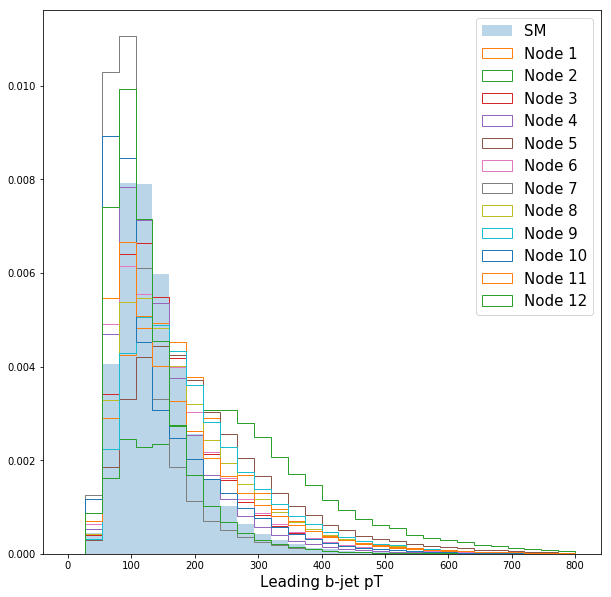

In [10]:
plt.figure(figsize=(10,10))
plt.hist(odd_sig_frame['ttH_ptjet1'], 
         weights=odd_sig_frame['benchmark_reweight_SM'], 
         bins=30, range=(0,800), 
         normed=True, alpha=0.3, label='SM')
for i in range(12):
    plt.hist(odd_sig_frame['ttH_ptjet1'], 
         weights=odd_sig_frame['benchmark_reweight_{}'.format(i)], 
         bins=30, range=(0,800), 
         normed=True, histtype='step', label='Node {}'.format(i+1))
plt.legend(loc='best', fontsize=15)
plt.xlabel('Leading b-jet pT', fontsize=15)

### Preprocessing

In [16]:
# Because of zero-padding, standardization needs special treatment
# Masked out zero

# Only normalize physical quantities
normalizable = ['ttH_sumET','ttH_MET','ttH_phiMET','ttH_dPhi1','ttH_dPhi2','ttH_PhoJetMinDr',
                'ttH_njets','ttH_Xtt0','ttH_Xtt1','ttH_pte1','ttH_pte2',
                'ttH_ptmu1','ttH_ptmu2','ttH_ptdipho',
                'ttH_etae1','ttH_etae2','ttH_etamu1','ttH_etamu2','ttH_etadipho',
                'ttH_phie1','ttH_phie2','ttH_phimu1','ttH_phimu2','ttH_phidipho',
                'ttH_fabs_CosThetaStar_CS','ttH_fabs_CosTheta_bb',
                'ttH_ptjet1','ttH_ptjet2','ttH_etajet1','ttH_etajet2',
                'ttH_phijet1','ttH_phijet2']

zero_entries = odd_bkg_frame[normalizable] == 0 
masked_x_sample = np.ma.array(odd_bkg_frame[normalizable], mask=zero_entries)
x_mean = masked_x_sample.mean(axis=0)
x_std = masked_x_sample.std(axis=0)
print("Mean and std calculated.")

# Standardize background
normed_bkg = (masked_x_sample - x_mean)/x_std

# Standardize background2 (ggH)
#zero_entries = bkg_frame2 == 0
#masked_x_sample = np.ma.array(bkg_frame2, mask=zero_entries)
#normed_bkg2 = (masked_x_sample - x_mean)/x_std

# Standardize signal
zero_entries = odd_sig_frame[normalizable] == 0 
masked_x_sample = np.ma.array(odd_sig_frame[normalizable], mask=zero_entries)
normed_sig = (masked_x_sample - x_mean)/x_std

normed_bkg_frame = pd.DataFrame(normed_bkg.filled(0), columns=list(odd_bkg_frame[normalizable]))
#normed_bkg_frame2 = pd.DataFrame(normed_bkg2.filled(0), columns=list(bkg_frame2))

normed_sig_frame = pd.DataFrame(normed_sig.filled(0), columns=list(odd_sig_frame[normalizable]))
normed_sig_frame.head()

def to_p_list(data_frame):
    # Inputs: Pandas data frame
    # Outputs: Numpy array of dimension (Event, Particle, Attributes)
    
    particle_list_sig = np.zeros(shape=(len(data_frame),8,7))
    sorted_particle_list = np.zeros(shape=(len(data_frame),8,7))
    #6: max particles: e1, e2, mu1, mu2, dipho, MET.
    #7: pt, eta, phi, isEle, isMuon, isDipho, isMET
    
    def isclose(a, b, rel_tol=1e-09, abs_tol=0.0):
        return abs(a-b) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)

   
    for i in range(len(data_frame)): # loop through the list of events
        pte1 = data_frame['ttH_pte1'].iloc[i]
        pte2 = data_frame['ttH_pte2'].iloc[i]
        ptmu1 = data_frame['ttH_ptmu1'].iloc[i]
        ptmu2 = data_frame['ttH_ptmu2'].iloc[i]
        ptdipho = data_frame['ttH_ptdipho'].iloc[i]
        ptjet1 = data_frame['ttH_ptjet1'].iloc[i]
        ptjet2 = data_frame['ttH_ptjet2'].iloc[i]
        ptMET = data_frame['ttH_MET'].iloc[i]

        etae1 = data_frame['ttH_etae1'].iloc[i]
        etae2 = data_frame['ttH_etae2'].iloc[i]
        etamu1 = data_frame['ttH_etamu1'].iloc[i]
        etamu2 = data_frame['ttH_etamu2'].iloc[i]
        etadipho = data_frame['ttH_etadipho'].iloc[i]
        etajet1 = data_frame['ttH_etajet1'].iloc[i]
        etajet2 = data_frame['ttH_etajet2'].iloc[i]
        etaMET = 0

        phie1 = data_frame['ttH_phie1'].iloc[i]
        phie2 = data_frame['ttH_phie2'].iloc[i]
        phimu1 = data_frame['ttH_phimu1'].iloc[i]
        phimu2 = data_frame['ttH_phimu2'].iloc[i]
        phidipho = data_frame['ttH_phidipho'].iloc[i]
        phijet1 = data_frame['ttH_phijet1'].iloc[i]
        phijet2 = data_frame['ttH_phijet2'].iloc[i]
        phiMET = data_frame['ttH_phiMET'].iloc[i]
        
        

        # list through list of particles: e1, e2, mu1, mu2, dipho, MET
        # 0: leading ele
        particle_list_sig[i,0, 0] = pte1
        particle_list_sig[i,0, 1] = etae1
        particle_list_sig[i,0, 2] = phie1
        particle_list_sig[i,0, 3] = 1 if not isclose(pte1,0) else 0 # isEle
        particle_list_sig[i,0, 4] = 0 # isMuon
        particle_list_sig[i,0, 5] = 0 # isDiPho
        particle_list_sig[i,0, 6] = 0 # isMET

        # 1: subleading ele
        particle_list_sig[i,1, 0] = pte2
        particle_list_sig[i,1, 1] = etae2
        particle_list_sig[i,1, 2] = phie2
        particle_list_sig[i,1, 3] = 1 if not isclose(pte2,0) else 0 # isEle
        particle_list_sig[i,1, 4] = 0 # isMuon
        particle_list_sig[i,1, 5] = 0 # isDiPho
        particle_list_sig[i,1, 6] = 0 # isMET

        # 2: leading muon
        particle_list_sig[i,2, 0] = ptmu1
        particle_list_sig[i,2, 1] = etamu1
        particle_list_sig[i,2, 2] = phimu1
        particle_list_sig[i,2, 3] = 0 # isEle
        particle_list_sig[i,2, 4] = 1 if not isclose(ptmu1,0) else 0 # isMuon
        particle_list_sig[i,2, 5] = 0 # isDiPho
        particle_list_sig[i,2, 6] = 0 # isMET

        # 3: subleading muon
        particle_list_sig[i,3, 0] = ptmu2
        particle_list_sig[i,3, 1] = etamu2
        particle_list_sig[i,3, 2] = phimu2
        particle_list_sig[i,3, 3] = 0 #isEle
        particle_list_sig[i,3, 4] = 1 if not isclose(ptmu2,0) else 0 # isMuon
        particle_list_sig[i,3, 5] = 0 # isDiPho
        particle_list_sig[i,3, 6] = 0 # isMET

        # 4: dipho
        particle_list_sig[i,4, 0] = ptdipho
        particle_list_sig[i,4, 1] = etadipho
        particle_list_sig[i,4, 2] = phidipho
        particle_list_sig[i,4, 3] = 0 # isEle
        particle_list_sig[i,4, 4] = 0 # isMuon
        particle_list_sig[i,4, 5] = 1 if not isclose(ptdipho,0) else 0 # isDiPho
        particle_list_sig[i,4, 6] = 0 # isMET

        # 5: MET
        particle_list_sig[i,5, 0] = ptMET
        particle_list_sig[i,5, 1] = etaMET
        particle_list_sig[i,5, 2] = phiMET
        particle_list_sig[i,5, 3] = 0 #isEle
        particle_list_sig[i,5, 4] = 0 # isMuon
        particle_list_sig[i,5, 5] = 0 # isDiPho
        particle_list_sig[i,5, 6] = 1 if not isclose(ptMET,0) else 0 # isMET
        
        particle_list_sig[i,6, 0] = ptjet1
        particle_list_sig[i,6, 1] = etajet1
        particle_list_sig[i,6, 2] = phijet1
        particle_list_sig[i,6, 3] = 0 #isEle
        particle_list_sig[i,6, 4] = 0 # isMuon
        particle_list_sig[i,6, 5] = 0 # isDiPho
        particle_list_sig[i,6, 6] = 0 # all zero means jet
        
        particle_list_sig[i,7, 0] = ptjet2
        particle_list_sig[i,7, 1] = etajet2
        particle_list_sig[i,7, 2] = phijet2
        particle_list_sig[i,7, 3] = 0 #isEle
        particle_list_sig[i,7, 4] = 0 # isMuon
        particle_list_sig[i,7, 5] = 0 # isDiPho
        particle_list_sig[i,7, 6] = 0 # all zero means jet
    
        # Sort by descending pT. 
        # This was implemented when standardization was done before sorting. Thus zero entry needs to be excluded
        # Redesigned the code with standardization done after sorting. Same code still works.
        nonzero_indices = np.nonzero(particle_list_sig[i,:,0])[0]
        sorted_indices = particle_list_sig[i,nonzero_indices,0].argsort()[::-1] # sort by first column, which is the pT
        global_sorted_indices = nonzero_indices[sorted_indices]
        sorted_particle_list[i,:len(nonzero_indices),:] = particle_list_sig[i,global_sorted_indices,:]
        
    return sorted_particle_list

sig_list = to_p_list(odd_sig_frame[normalizable])
bkg_list = to_p_list(odd_bkg_frame[normalizable])
#bkg_list2 = to_p_list(bkg_frame2)

# Standardize the particle list
x_sample = bkg_list[:,:,:3] # don't standardize boolean flags
# Flatten out
x_flat = x_sample.reshape((x_sample.shape[0]*x_sample.shape[1], x_sample.shape[2]))
# Masked out zero
zero_entries = x_flat == 0 
masked_x_sample = np.ma.array(x_flat, mask=zero_entries)
x_list_mean = masked_x_sample.mean(axis=0)
x_list_std = masked_x_sample.std(axis=0)
print("Mean and std calculated for particle list.")
del x_sample, x_flat, zero_entries, masked_x_sample # release the memory

def standardize_p_list(inputs):
    global x_list_mean, x_list_std
    to_norm = inputs[:,:,:3]
    zero_entries = to_norm == 0
    masked_to_norm = np.ma.array(to_norm, mask=zero_entries)
    normed_x = (masked_to_norm - x_list_mean)/x_list_std
    return np.concatenate((normed_x.filled(0), inputs[:,:,3:]), axis=2)
    
normed_sig_list = standardize_p_list(sig_list)
normed_bkg_list = standardize_p_list(bkg_list)

background_weight = odd_bkg_frame['weight'].values
signal_weight = odd_sig_frame['weight'].values

signal_allnode_weight = odd_sig_frame['sumallnode_reweight'].values
background_allnode_weight = np.ones(shape=(len(background_weight),))

signal_nodeweight = odd_sig_frame[['benchmark_reweight_0',
                                   'benchmark_reweight_1',
                                   'benchmark_reweight_2',
                                   'benchmark_reweight_3',
                                   'benchmark_reweight_4',
                                   'benchmark_reweight_5',
                                   'benchmark_reweight_6',
                                   'benchmark_reweight_7',
                                   'benchmark_reweight_8',
                                   'benchmark_reweight_9',
                                   'benchmark_reweight_10',
                                   'benchmark_reweight_11',
                                   'benchmark_reweight_SM',
                                  ]].values

background_nodeweight = np.ones(shape=(len(background_weight), signal_nodeweight.shape[1]))

#normed_bkg_list2 = standardize_p_list(bkg_list2)

normed_sig_hlf = normed_sig_frame[['ttH_sumET','ttH_dPhi1','ttH_dPhi2','ttH_PhoJetMinDr','ttH_njets','ttH_Xtt0',
                                   'ttH_Xtt1','ttH_fabs_CosThetaStar_CS','ttH_fabs_CosTheta_bb']].values
normed_bkg_hlf = normed_bkg_frame[['ttH_sumET','ttH_dPhi1','ttH_dPhi2','ttH_PhoJetMinDr','ttH_njets','ttH_Xtt0',
                                   'ttH_Xtt1','ttH_fabs_CosThetaStar_CS','ttH_fabs_CosTheta_bb']].values
#normed_bkg_hlf2 = normed_bkg_frame2[['ttH_sumET','ttH_dPhi1','ttH_dPhi2','ttH_PhoJetMinDr','ttH_njets','ttH_Xtt0',
#                                   'ttH_Xtt1','ttH_fabs_CosThetaStar_CS','ttH_fabs_CosTheta_bb']].values
    

def downsample(signal, background, randix=None):
    '''
    Take 2 datasets (multidimensional np array), 
    downsample the big one to the small one. 
    Before downsampling, rearrange the big one according to randix. 
    If randix is not given, shuffle the big sample.
    
    Return 2 samples in the same order and the randix.
    '''
    
    if len(signal)<len(background):
        target_sample = signal
        big_sample = background
        signal_is_smaller = 1
    else:
        target_sample = background
        big_sample = signal
        signal_is_smaller = 0
    
    if not isinstance(randix, np.ndarray):
        randix = np.arange(len(big_sample))
        np.random.shuffle(randix)
    
    big_sample = big_sample[randix]
    big_sample = big_sample[:len(target_sample)]
    
    if signal_is_smaller:
        return target_sample, big_sample, randix
    
    return big_sample, target_sample, randix
    
signal_list, background_list, randix = downsample(normed_sig_list, normed_bkg_list)
signal_hlf, background_hlf, randix = downsample(normed_sig_hlf, normed_bkg_hlf, randix)
signal_weight, background_weight, randix = downsample(signal_weight, background_weight, randix)
signal_nodeweight, background_nodeweight, randix = downsample(signal_nodeweight, background_nodeweight, randix)
signal_allnode_weight, background_allnode_weight, randix = downsample(signal_allnode_weight, background_allnode_weight, randix)

sig_label = np.ones(len(signal_list))
bkg_label = np.zeros(len(background_list))

data_list = np.concatenate((signal_list,background_list))
data_hlf = np.concatenate((signal_hlf,background_hlf))
label = np.concatenate((sig_label,bkg_label))
data_weight = np.concatenate((signal_weight, background_weight))
data_nodeweight = np.concatenate((signal_nodeweight, background_nodeweight))
data_allnode_weight = np.concatenate((signal_allnode_weight, background_allnode_weight))


print("Data list: {}".format(data_list.shape))
print("Data HLF: {}".format(data_hlf.shape))
print("Label: {}".format(label.shape))
print("Data weight: {}".format(data_weight.shape))
print("Data nodeweight: {}".format(data_nodeweight.shape))
print("Data sum allnode weight: {}".format(data_allnode_weight))
skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(data_hlf, label)
print(skf)




Mean and std calculated.
Mean and std calculated for particle list.
Data list: (106794, 8, 7)
Data HLF: (106794, 9)
Label: (106794,)
Data weight: (106794,)
Data nodeweight: (106794, 13)
Data sum allnode weight: [ 2.91348977  2.62703358  2.95508106 ...,  1.          1.          1.        ]
StratifiedKFold(n_splits=5, random_state=None, shuffle=True)


In [18]:
### Index of HLF

for i,hlf in enumerate(normalizable):
    print(i, hlf)

(0, 'ttH_sumET')
(1, 'ttH_MET')
(2, 'ttH_phiMET')
(3, 'ttH_dPhi1')
(4, 'ttH_dPhi2')
(5, 'ttH_PhoJetMinDr')
(6, 'ttH_njets')
(7, 'ttH_Xtt0')
(8, 'ttH_Xtt1')
(9, 'ttH_pte1')
(10, 'ttH_pte2')
(11, 'ttH_ptmu1')
(12, 'ttH_ptmu2')
(13, 'ttH_ptdipho')
(14, 'ttH_etae1')
(15, 'ttH_etae2')
(16, 'ttH_etamu1')
(17, 'ttH_etamu2')
(18, 'ttH_etadipho')
(19, 'ttH_phie1')
(20, 'ttH_phie2')
(21, 'ttH_phimu1')
(22, 'ttH_phimu2')
(23, 'ttH_phidipho')
(24, 'ttH_fabs_CosThetaStar_CS')
(25, 'ttH_fabs_CosTheta_bb')
(26, 'ttH_ptjet1')
(27, 'ttH_ptjet2')
(28, 'ttH_etajet1')
(29, 'ttH_etajet2')
(30, 'ttH_phijet1')
(31, 'ttH_phijet2')


In [7]:
with h5py.File("data2017_allnode.h5","w") as output:
    output.create_dataset("list", data=data_list)
    output.create_dataset("hlf", data=data_hlf)
    output.create_dataset("weight", data=data_weight)
    output.create_dataset("nodeweight",data=data_nodeweight)
    output.create_dataset("sumallnode_weight",data=data_allnode_weight)
    output.create_dataset("label",data=label)
    print("Finish writing to data2017_allnode.h5")


Finish writing to data2017_allnode.h5


In [8]:
x_mean.dump("mean"+year+".npy")
x_std.dump("std"+year+".npy")

In [9]:
x_mean = np.load('mean'+year+'.npy')
x_std = np.load('std'+year+'.npy')
print(np.array2string(x_mean, separator=', '))
print(np.array2string(x_std, separator=', '))

[  3.22491144e+02,   7.22919780e+01,   1.49387571e-01,   4.94052483e-03,
   5.10246425e-04,   1.38947662e+00,   5.31453078e+00,   7.45455854e+00,
   1.35956692e+02,   7.06566234e+01,   3.71319449e+01,   6.74400372e+01,
   3.78045958e+01,   1.73739779e+02,   2.44105199e-02,   8.74739133e-02,
  -1.06521292e-02,  -8.08607645e-02,  -5.39241839e-03,  -3.57037140e-02,
   1.59510158e-01,   2.73751540e-02,   1.89251401e-02,  -4.07854484e-03,
   4.75087259e-01,   4.65906361e-01,   1.23640841e+02,   5.92089022e+01,
  -8.63826805e-03,  -4.54561747e-03,  -2.04075881e-02,   5.20315820e-03]
[  2.23688125e+02,   6.14480046e+01,   1.89750669e+00,   1.84765326e+00,
   1.81706814e+00,   6.16140431e-01,   1.57790173e+00,   1.21559976e+01,
   3.18350560e+02,   5.51059043e+01,   2.27778847e+01,   5.34930606e+01,
   2.33020848e+01,   1.13925303e+02,   1.07162645e+00,   1.11756573e+00,
   1.06602334e+00,   1.05170943e+00,   1.03730169e+00,   1.79671005e+00,
   1.76463679e+00,   1.81416114e+00,   1.72905029e+

### Mean and std of particle list's pt, eta, phi

In [10]:
print(np.array2string(x_list_mean, separator=', '))

[  1.04960120e+02,  -5.49804481e-03,   3.08285275e-02]


In [12]:
len(x_mean)

32

In [13]:
print(np.array2string(x_list_std, separator=', '))

[ 85.77034272,   1.03762195,   1.83170033]


(array([  7.51220000e+04,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   8.71760000e+04,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   5.28870000e+04,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.31520000e+04,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   8.47400000e+03,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.68200000e+03,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   7.91000000e+02,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

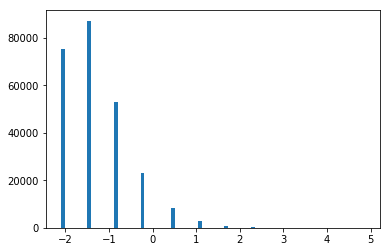

In [14]:
plt.hist(normed_sig_frame['ttH_njets'],bins=80)